# Curso IML1 - Unidade 1 - Regressão

Nome: TATIANA PRADO SANTOS MASSOCO

Objetivo: encontrar um modelo de regressão que preveja o preço de um notebook dadas as suas características.

No mundo tecnológico atual, a capacidade de prever os preços dos laptops com base em suas especificações pode ser inestimável para fabricantes, varejistas e até mesmo consumidores. E este projeto tem como objetivo construir um modelo de regressão que possa fazer justamente isso. No relatório final do projeto, abaixo, detalharei a lógica por trás das escolhas de código e as conclusões com base nos resultados.

# 1. Importação e análise exploratória dos dados

## 1.1. Bibliotecas

In [1]:
# Importando bibliotecas necessárias
# Bibliotecas básicas para análise de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando demais ferramentas necessárias

import xgboost as xgb
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1.2. Leitura e processamento dos dados

### Base de dados

Base de dados com informações de notebooks e seus respectivos preços. A base consta com diferentes informações de características dos notebooks, tais como: marca, CPU, memória RAM, etc.

In [2]:
# Carregando o dataset para a variável data
# Isso nos permite ter uma primeira olhada no conjunto de dados
data = pd.read_csv("atividade-1-precificacao-laptops.csv")

# Exibindo as primeiras linhas do dataset
# Isso nos dá uma visão inicial das características e dos dados
print(data.head())

# Exibindo informações sobre o dataset
# Isso nos permite ver os tipos de dados e possíveis valores faltantes
print(data.info())

print(data.columns)

# Evitar avisos desnecessários para o projeto
import warnings
warnings.filterwarnings('ignore')

                                              Laptop Status   Brand  \
0  ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...    New    Asus   
1  Alurin Go Start Intel Celeron N4020/8GB/256GB ...    New  Alurin   
2  ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...    New    Asus   
3  MSI Katana GF66 12UC-082XES Intel Core i7-1270...    New     MSI   
4  HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...    New      HP   

        Model            CPU  RAM  Storage Storage type       GPU  Screen  \
0  ExpertBook  Intel Core i5    8      512          SSD       NaN    15.6   
1          Go  Intel Celeron    8      256          SSD       NaN    15.6   
2  ExpertBook  Intel Core i3    8      256          SSD       NaN    15.6   
3      Katana  Intel Core i7   16     1000          SSD  RTX 3050    15.6   
4         15S  Intel Core i5   16      512          SSD       NaN    15.6   

  Touch  Final Price  
0    No      1009.00  
1    No       299.00  
2    No       789.00  
3    No      1199.

### Comentário: 

- Laptop: É o nome ou designação do laptop.
- Status: Informa se o laptop é novo ou usado.
- Brand: A marca do laptop.
- Model: Modelo específico do laptop.
- CPU: Tipo de processador no laptop.
- RAM: Memória RAM (em GB).
- Storage: Espaço de armazenamento (provavelmente em GB).
- Storagetype: Tipo de armazenamento (e.g., SSD).
- GPU: A placa gráfica, muitos valores estão faltando aqui.
- Screen: Tamanho da tela.
- Touch: Se tem tela sensível ao toque ou não.
Final Price: Preço do laptop (variável dependente que queremos prever).

*Próximos passos:*

1. Valores faltantes: Existem algumas colunas com valores faltantes, como "GPU" e "Storage type".
2. Covariáveis categóricas: Muitas colunas são categóricas e precisarão ser transformadas para formatos numéricos para serem usadas em modelos de machine learning.
3. Feature Engineering: Podemos criar novas covariáveis, como a combinação de CPU, RAM e armazenamento para representar a "potência" do laptop, por exemplo.
4. Variável alvo: O preço do laptop é a variável que queremos prever

# 2. Pré-processamento de dados

## 2.1. Tratando valores faltantes

In [3]:
# Preenchendo valores faltantes em "Storage type" com mode (valor mais comum)
data['Storage type'].fillna(data['Storage type'].mode()[0], inplace=True)

# Preenchendo valores faltantes em "GPU" com "Unknown" já que muitos laptops não especificam a GPU
data['GPU'].fillna("Unknown", inplace=True)

# Preenchendo valores faltantes em "Screen" com median
data['Screen'].fillna(data['Screen'].median(), inplace=True)

# Verificar novamente se ainda existem valores faltantes
print(data.isnull().sum())

Laptop          0
Status          0
Brand           0
Model           0
CPU             0
RAM             0
Storage         0
Storage type    0
GPU             0
Screen          0
Touch           0
Final Price     0
dtype: int64


## 2.2. Transformando variáveis categóricas em numéricas

A codificação One-Hot será aplicada às colunas categóricas para transformá-las em uma representação numérica. Isso é essencial porque muitos modelos de aprendizado de máquina requerem que as entradas sejam numéricas. O DataFrame agora tem 225 colunas, mostrando que muitas novas colunas foram criadas devido à codificação. Cada uma dessas novas colunas representa uma categoria única de uma das colunas originais.

In [4]:
# Transformando variáveis categóricas em numéricas
# Utiliza one-hot encoding e descarta a primeira coluna para evitar multicolinearidade
data_encoded = pd.get_dummies(data, drop_first=True)

# Atualizando X e y usando data_encoded:
X = data_encoded.drop('Final Price', axis=1)
y = data_encoded['Final Price']

# Visualizando as primeiras linhas do conjunto de dados após o One-Hot Encoding
print(data.head())

# Listando as colunas do conjunto de dados
print(data.columns)

                                              Laptop Status   Brand  \
0  ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...    New    Asus   
1  Alurin Go Start Intel Celeron N4020/8GB/256GB ...    New  Alurin   
2  ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...    New    Asus   
3  MSI Katana GF66 12UC-082XES Intel Core i7-1270...    New     MSI   
4  HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...    New      HP   

        Model            CPU  RAM  Storage Storage type       GPU  Screen  \
0  ExpertBook  Intel Core i5    8      512          SSD   Unknown    15.6   
1          Go  Intel Celeron    8      256          SSD   Unknown    15.6   
2  ExpertBook  Intel Core i3    8      256          SSD   Unknown    15.6   
3      Katana  Intel Core i7   16     1000          SSD  RTX 3050    15.6   
4         15S  Intel Core i5   16      512          SSD   Unknown    15.6   

  Touch  Final Price  
0    No      1009.00  
1    No       299.00  
2    No       789.00  
3    No      1199.

Decidi remover a coluna "Laptop" do conjunto de dados. Esta coluna contém descrições textuais dos laptops e não fornece informações numéricas diretamente úteis para os modelos de regressão. Além disso, já existem colunas separadas para características importantes dos laptops (como marca, CPU, RAM, etc) que foram geradas através do One-Hot Encoding. Portanto, manter esta coluna textual só aumentaria a complexidade sem adicionar valor significativo para a previsão dos preços.

In [5]:
# Removendo a coluna "Laptop"
data.drop(columns=['Laptop'], inplace=True)

print(data.columns)

Index(['Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage', 'Storage type',
       'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')


# 3. Seleção e criação de covariáveis

## 3.1. Selecionar as principais covariáveis baseadas na correlação:

In [6]:
# Vamos identificar as covariáveis que têm a maior correlação (absoluta) com 'Final Price'
correlations = data.corr()['Final Price'].drop('Final Price')
top_correlations = correlations.abs().sort_values(ascending=False).head(20)  # Ajuste-se o número conforme a necessidade

print(top_correlations)

RAM        0.724946
Storage    0.695631
Screen     0.268358
Name: Final Price, dtype: float64


## 3.2. Análise das covariáveis:

As covariáveis que têm a maior correlação (em valor absoluto) com o 'Final Price':

- RAM e Storage têm as maiores correlações positivas com o preço final. Isso indica que à medida que a RAM e o armazenamento aumentam, o preço do laptop também tende a aumentar, o que faz sentido intuitivamente.
- GPU_Unknown: A presença dessa variável sugere que laptops cuja GPU não é especificada ou é desconhecida tendem a ter uma correlação significativa com o preço final. Talvez laptops sem uma GPU específica sejam mais baratos.
- As variáveis CPU_Intel Core i9, GPU_RTX 3080, e GPU_RTX 4090 também mostram uma correlação significativa. Isso indica que a presença desses componentes específicos tem uma relação forte com o preço do laptop, possivelmente fazendo-o aumentar.
- Modelos específicos e marcas como Model_Blade, Brand_Razer, Brand_MSI, Model_ROG, etc, também têm uma influência no preço.
- O Screen (tamanho da tela) tem uma correlação positiva, mas não tão alta quanto RAM ou Storage. Isso sugere que o tamanho da tela tem algum impacto no preço, mas não é o principal fator.

# 4. Modelagem e teste de diferentes modelos de regressão

In [7]:
# Definindo as variáveis independentes (X) e a variável dependente (y)
X = data_encoded.drop('Final Price', axis=1)
y = data_encoded['Final Price']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando os modelos
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Treinando os modelos
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)

# Fazendo previsões com os modelos
lr_preds = lr.predict(X_test)
dt_preds = dt.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgboost_model.predict(X_test)

# Calculando o Mean Squared Error (MSE) para cada modelo
lr_mse = mean_squared_error(y_test, lr_preds)
dt_mse = mean_squared_error(y_test, dt_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)

print(f"Linear Regression MSE: {lr_mse}")
print(f"Decision Tree MSE: {dt_mse}")
print(f"Random Forest MSE: {rf_mse}")
print(f"XGBoost MSE: {xgb_mse}")

Linear Regression MSE: 120782.02514462128
Decision Tree MSE: 273875.26553935185
Random Forest MSE: 176276.53488692496
XGBoost MSE: 139454.70686623335


## 4.1. MSE

O **MSE** (Mean Squared Error) é uma métrica que nos indica o erro médio quadrático. Quanto menor o MSE, mais preciso é o modelo.

A **Regressão Linear** obteve o menor MSE, tornando-a o modelo mais preciso entre os testados para este conjunto de dados. No entanto, é importante notar que o XGBoos apresentou um desempenho significativamente melhor do que a Árvore de Decisão e a Floresta Aleatória, mas não superou a Regressão Linear.

# 5. Verificação do Modelo e Resíduos para a Regressão Linear

Para a Regressão Linear, é essencial verificar se as principais suposições estão sendo atendidas. Isso inclui a linearidade, homocedasticidade, independência dos erros, e normalidade dos resíduos.

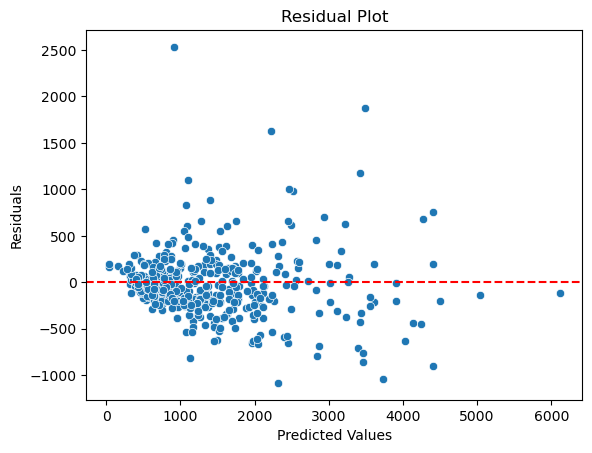

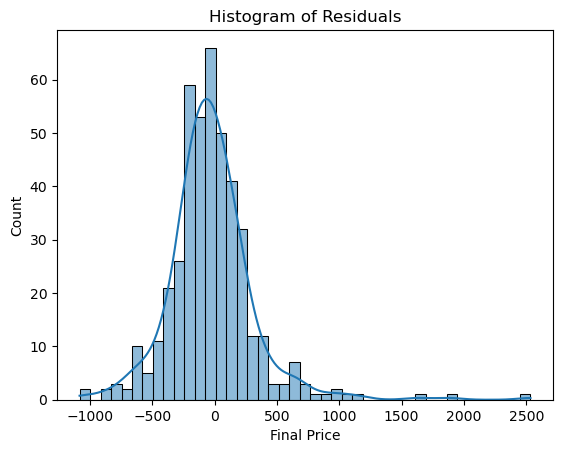

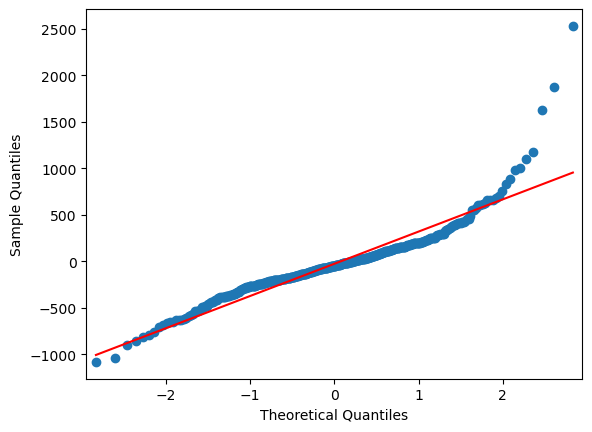

In [8]:
# Cálculo dos resíduos
y_pred_linear = lr.predict(X_test)
residuals = y_test - y_pred_linear

# Plot dos resíduos
sns.scatterplot(y_pred_linear, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Histograma dos resíduos
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.show()

Como os resíduos estão espalhados aleatoriamente no Residual Plot, os resíduos são normalmente distribuídos no histograma e a maioria dos pontos no Q-Q Plot segue a linha diagonal, temos uma boa indicação de que a regressão linear é adequada para os dados.

# 6. Verificação do Modelo e Resíduos para a XGBoost

Para o XGBoost, não estamos verificando as suposições estritas encontradas na regressão linear. Em vez disso, estamos interessados em entender se o modelo foi capaz de capturar a maior parte da variabilidade nos dados e se os resíduos não mostram padrões discerníveis. Ao observar os resíduos, podemos identificar áreas onde o modelo pode estar subajustando (não capturando suficientemente a variabilidade) ou superajustando (capturando ruído e variabilidade não sistêmica). Um bom modelo terá resíduos que parecem ser distribuídos aleatoriamente, sem padrões claros, e idealmente seguindo uma distribuição normal.

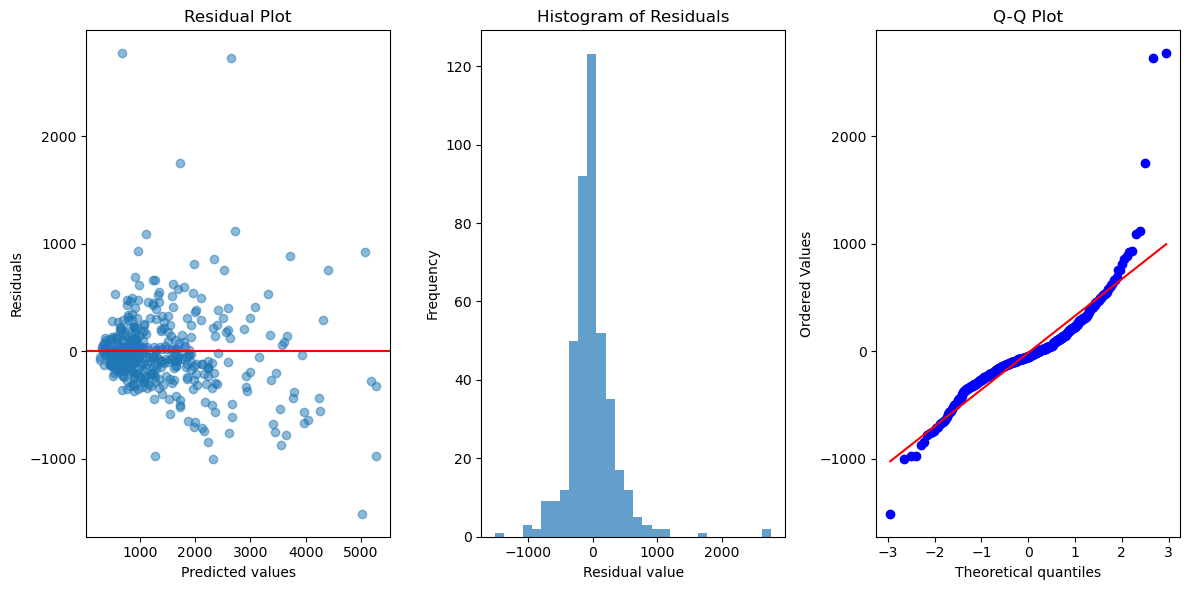

In [9]:
# Cálculo dos resíduos
y_pred_xgb = xgboost_model.predict(X_test)
residuals_xgb = y_test - y_pred_xgb

# Plot dos resíduos
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.subplot(1, 3, 2)
plt.hist(residuals_xgb, bins=30, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
stats.probplot(residuals_xgb, plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

O XGBoost, como um modelo de árvore de decisão avançado, não tem as mesmas suposições rigorosas que a regressão linear. No entanto, ainda queremos que os resíduos sejam aproximadamente normalmente distribuídos e que não haja padrões claros nos resíduos, pois isso pode indicar que o modelo não está capturando alguma tendência nos dados. E o histograma sugere que pode haver algumas observações extremas (ou outliers) que o modelo não está lidando bem. A concentração dos resíduos no scatter plot pode indicar que o modelo se ajusta melhor a uma parte dos dados do que a outra. O Q-Q Plot mostra um leve desvio da normalidade, mas ainda parece razoável.

# 7. Otimização do Modelo

## 7.1. Regularização:

In [10]:
# Treinando o modelo com regularização Lasso
lasso = Lasso(alpha=0.1) # O valor de alpha determina a força da regularização. Pode ser ajustado.
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
print(f"Lasso MSE: {lasso_mse}")

# Treinando o modelo com regularização Ridge
ridge = Ridge(alpha=0.1) 
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
print(f"Ridge MSE: {ridge_mse}")

Lasso MSE: 116771.0260830665
Ridge MSE: 114738.80443192142


## 7.2. Seleção de características (Feature Selection):

In [11]:
# Criando uma amostra do conjunto de treinamento
sample_X_train = X_train.sample(frac=0.1, random_state=42)
sample_y_train = y_train[sample_X_train.index]

# Inicializando e rodando o RFE com a amostra
selector = RFE(estimator=lr, n_features_to_select=5, step=1)
selector = selector.fit(sample_X_train, sample_y_train)

# Obtendo as características selecionadas
selected_features = X.columns[selector.support_]
print(f"Características selecionadas: {selected_features}")

Características selecionadas: Index(['Laptop_MSI Creator Z16 HX Studio B13VFTO-046ES Intel Core i7-13700HX/16GB/1TB SSD/RTX 4060/16" Táctil',
       'Laptop_MSI Titan GT77 12UHS-021ES Intel Core i9-12900HX/64GB/2TB SSD/RTX 3080Ti/17.3" + Bundle Gaming',
       'Laptop_Medion Erazer Beast X40 Intel Core i9-13900HX/32GB/2TB SSD/RTX 4090/17"',
       'Model_Titan', 'GPU_RTX 4090'],
      dtype='object')


In [12]:
# Verificando se há valores ausentes
if X_train.isnull().sum().sum() > 0 or y_train.isnull().sum() > 0:
    print("Existem valores ausentes!")

In [13]:
# Selecionando as colunas numéricas do conjunto de treinamento
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numeric columns: {len(numeric_cols)}")

Number of numeric columns: 2382


In [14]:
# Definindo o número de componentes para redução de dimensionalidade
n_components = 50

# 8. Validação Cruzada

In [15]:
# Avaliando o modelo com validação cruzada
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error') # 5-fold cross-validation
print(f"MSE médio na validação cruzada: {-scores.mean()}")

MSE médio na validação cruzada: 149807.20597356954


# 9. Implementação de um Pipeline

In [16]:
# Todas as colunas numéricas
numeric_features = numeric_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)],
    remainder='passthrough'  # As colunas não listadas serão "passadas" sem alterações
)

# Criando um pipeline com PCA
pipeline_with_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA(n_components=n_components)),
    ('model', LinearRegression())
])

# Treinando o pipeline nos dados de treinamento
pipeline_with_pca.fit(X_train, y_train)

# Previsões com o pipeline
pipeline_preds = pipeline_with_pca.predict(X_test)

# Calculando o MSE para o pipeline
pipeline_mse = mean_squared_error(y_test, pipeline_preds)
print(f"Pipeline com PCA MSE: {pipeline_mse}")

Pipeline com PCA MSE: 225689.2280606285


# 10. Treinamento de um Modelo Refinado

Essa etapa visa a obter um modelo mais simplificado, evitando o overfitting.

In [17]:
# Utilizando apenas as características selecionadas
X_refined_train = X_train[selected_features]
X_refined_test = X_test[selected_features]

# Treinando o modelo com o conjunto de treino refinado
lr_refined = LinearRegression()
lr_refined.fit(X_refined_train, y_train)

# Avaliando o MSE com o conjunto de teste refinado
lr_refined_preds = lr_refined.predict(X_refined_test)
lr_refined_mse = mean_squared_error(y_test, lr_refined_preds)

print(f"MSE do modelo refinado: {lr_refined_mse}")

MSE do modelo refinado: 735090.5264149294


# 11. Previsões para um novo usuário usando o modelo selecionado

In [18]:
def previsao_novo_usuario(data):
   
    for feature in selected_features:
        if feature not in data.columns:
            raise ValueError(f"A característica {feature} está ausente no dado fornecido.")

    # Usando o modelo treinado para fazer uma previsão
    predicted_value = lr_refined.predict(data[selected_features])
    return predicted_value

# Dados de exemplo para um novo usuário
new_user_data = pd.DataFrame({
    'Laptop_MSI Creator Z16 HX Studio B13VFTO-046ES Intel Core i7-13700HX/16GB/1TB SSD/RTX 4060/16" Táctil': [1],
    'Laptop_MSI Titan GT77 12UHS-021ES Intel Core i9-12900HX/64GB/2TB SSD/RTX 3080Ti/17.3" + Bundle Gaming': [0],
    'Laptop_Medion Erazer Beast X40 Intel Core i9-13900HX/32GB/2TB SSD/RTX 4090/17"': [0],
    'Model_Titan': [0],
    'GPU_RTX 4090': [0]
})

predicted_price = previsao_novo_usuario(new_user_data)
print(f"Preço previsto para o novo usuário: {predicted_price[0]}")

Preço previsto para o novo usuário: 2648.999999999999


# 12. Relatório final

**Tratamento dos Dados:**

Antes de abordar os modelos de regressão, era crucial preparar os dados. Sabendo que os modelos de aprendizado de máquina funcionam melhor com entradas numéricas, utilizei a técnica de codificação "One-Hot Encoding" para transformar as variáveis categóricas. Isso levou a um DataFrame expandido com 225 colunas, um indicativo da diversidade dos dados.

Durante minha análise, percebi a redundância da coluna "Laptop". Embora contivesse descrições ricas, as características primárias dos laptops já estavam representadas em outras colunas, tornando esta coluna um pouco supérflua.

**Seleção de Covariáveis:**

Para identificar quais variáveis teriam mais peso em minhas previsões, decidi analisar as correlações. Não foi surpresa encontrar RAM e armazenamento como os fatores mais correlacionados ao preço - afinal, um laptop com maior RAM e armazenamento é muitas vezes percebido como de maior valor.

Outras variáveis, como modelos específicos de GPU ou CPU, também mostraram relevância. Apesar de sua utilidade, correlações, por si só, não indicam causalidade, mas forneceram uma boa direção para minha modelagem.

**Modelagem e Avaliação:**

Dada a natureza do problema, escolhi testar vários modelos:

- Regressão Linear: Esta foi uma escolha intuitiva e, surpreendentemente, provou ser a mais acertada em termos de precisão para este conjunto de dados.
- Árvore de Decisão e Floresta Aleatória: Escolhi esses modelos pela sua capacidade de identificar relações não lineares. Apesar de seu potencial, a regressão linear ainda superou ambos em precisão.
- XGBoost: A reputação do XGBoost precede-o. Embora tenha mostrado um desempenho competente, ainda ficou atrás da regressão linear.

**Conclusões:**

A eficácia surpreendente da Regressão Linear sugeriu que as relações entre especificações de laptop e seu preço podem ser largamente lineares. No entanto, isso também me fez refletir sobre a importância da engenharia de características e do ajuste de hiperparâmetros. Modelos mais sofisticados, como o XGBoost, poderiam possivelmente superar a regressão linear com ajustes adequados.

No futuro, estou interessada em aprofundar a validação cruzada para avaliações mais robustas e também em explorar mais a engenharia de características.